## OCOM5203M Assignment 1 - Image Caption Generation [100 marks]

In [56]:
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd


Detect which device (CPU/GPU) to use.

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]

### 1.1 EncoderCNN

In [58]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet152(
            weights=models.ResNet152_Weights.DEFAULT)

        # remove the last layer of resnet
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""

        with torch.no_grad():
            features = self.resnet(images)
            features = features.view(features.size(0), -1)
            return features


In [59]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
# save the encoder
torch.save(encoder.state_dict(), 'export/encoder-5-3000.pkl')
encoder.eval()


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

### 1.2 Processing the images

In [60]:
class CocoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.coco_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.coco_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # image id
        img_id = self.coco_frame["id"][idx]
        # image path
        img_name = os.path.join(
            self.root_dir, self.coco_frame["file_name"][idx])  # type: ignore
        image = plt.imread(img_name)
        # convert single channel images to 3 channels
        if len(image.shape) == 2:
            image = np.stack((image,)*3, axis=-1)
        if self.transform:
            image = self.transform(image)
        return image, img_id


In [61]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])


In [62]:
dataset = CocoDataset(csv_file='data/coco_subset_meta.csv',
                      root_dir='data/images', transform=data_transform)


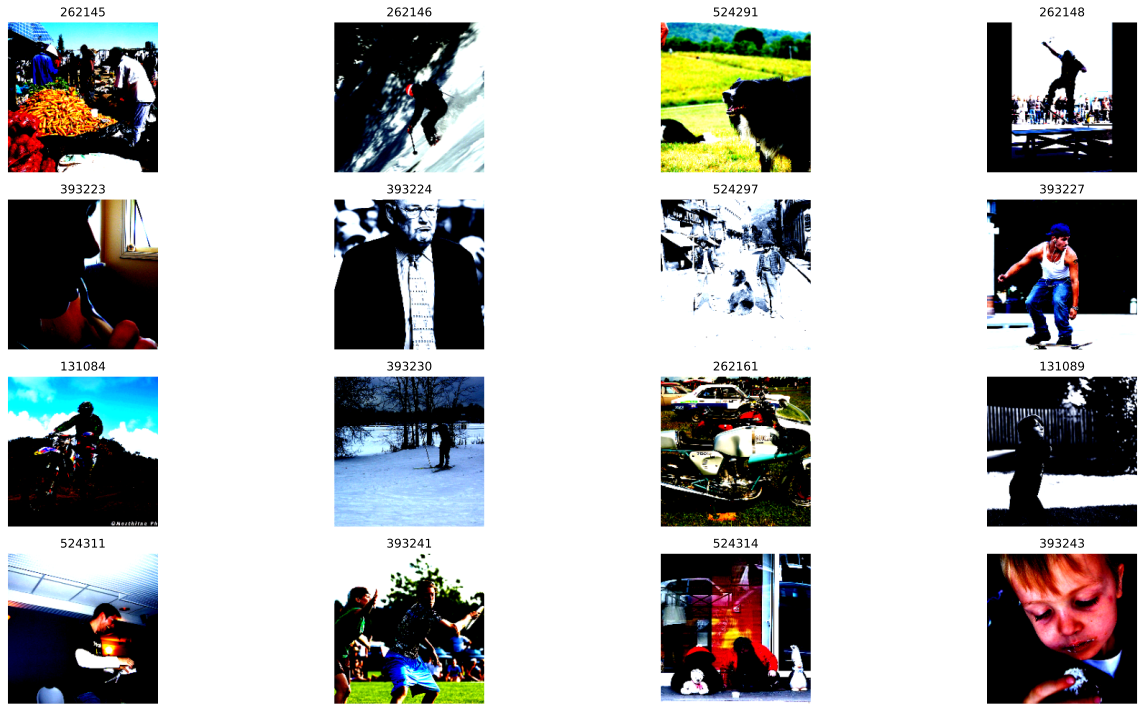

In [63]:
def plot_data(dataset, size=(4, 4)):
    fig, axes = plt.subplots(*size, figsize=(20, 10))
    for i, ax in enumerate(axes.flatten()):  # type: ignore
        img, img_id = dataset[i]
        img = img.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        img = np.clip(img, 0, 1)  # clip values to [0, 1]
        ax.imshow(img)
        ax.set_title(img_id)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('export/images.png')
    plt.show()


plot_data(dataset)


In [64]:
def extract_features(encoder, loader):
    if not os.path.isfile('export/features.pt') or not os.path.isfile('export/image_features.csv'):
        print('Extracting features...')
        imaged_id_to_feature_index = pd.DataFrame(
            columns=["image_id", "feature_index"])
        features = torch.zeros((0, 2048)).to(device)

        for i, (images, image_ids) in enumerate(loader):
            images = images.to(device)
            features_batch = encoder(images)
            features = torch.cat((features, features_batch), dim=0)
            image_id_to_feature_index_batch = pd.DataFrame(
                {"image_id": image_ids, "feature_index": range(i*64, (i+1)*64)})
            imaged_id_to_feature_index = pd.concat(
                [imaged_id_to_feature_index, image_id_to_feature_index_batch], ignore_index=True)
            print(f"\rExtracting features: {i+1}/{len(loader)}", end="")
        print()
        print("\rExtracting features: Done!")

        # save the features
        torch.save(features, 'export/features.pt')
        imaged_id_to_feature_index.to_csv(
            'export/image_features.csv', index=False)
    else:
        print(f'Loaded features from file export/features.pt')
        features = torch.load('export/features.pt')
        imaged_id_to_feature_index = pd.read_csv('export/image_features.csv')

    return features, imaged_id_to_feature_index


In [65]:
features, imaged_id_to_feature_index = extract_features(
    encoder, DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0))


Loaded features from file export/features.pt


## 2 Text preparation [23 marks]


### 2.1 Build the caption dataset


In [66]:
def load_captions(export_path, ids):
    import json

    # check if captions file exists
    if not os.path.isfile(export_path):
        captions = json.load(
            open("data/annotations/captions_train2017.json", 'r'))['annotations']
        print("total number of captions (original): ", len(captions))
        # captions += (json.load(open("data/annotations/captions_val2017.json", 'r')))['annotations']
        # print("total number of captions: ", len(captions))

        if captions is None:
            raise Exception("No captions found")

        # save json file
        with open('export/captions.json', 'w') as f:
            json.dump(captions, f)

        # json to dataframe
        captions = pd.DataFrame(captions)
        captions.head()

        # filter captions by ids
        captions = captions[captions['image_id'].isin(ids)]

        print("total number of captions (filtered): ", len(captions))

        # save captions
        captions.to_csv(export_path, index=False)
        print(f"captions saved to csv file {export_path}")
    else:
        captions = pd.read_csv(export_path)
        print(
            f"captions loaded from csv file {export_path}, size {len(captions)}")
    return captions


In [67]:
captions = load_captions('export/captions.csv',
                         imaged_id_to_feature_index["image_id"].unique())


captions loaded from csv file export/captions.csv, size 25154


In [68]:
# cross reference captions with image features
missing_values = ~imaged_id_to_feature_index['image_id'].isin(
    captions['image_id'])
print(
    f"total missing captions: {missing_values.sum()} ({missing_values.sum()/len(missing_values)*100:.2f}%)")

del missing_values


total missing captions: 0 (0.00%)


In [69]:
# total rows with same image_id and caption
print(
    f"total rows with same image_id and caption: {len(captions[captions.duplicated(subset=['image_id', 'caption'])])}")


total rows with same image_id and caption: 7


In [70]:
# remove duplicated rows with same image_id and caption
print(f"total captions before: {len(captions)}")
captions = captions.drop_duplicates(subset=['image_id', 'caption'])
print(f"total captions after: {len(captions)}")


total captions before: 25154
total captions after: 25147


In [71]:
# total rows with same image_id and caption
print(
    f"total rows with same image_id and caption: {len(captions[captions.duplicated(subset=['image_id', 'caption'])])}")


total rows with same image_id and caption: 0


In [72]:
# plot images with captions
def plot_captions(dataset, captions, size=(4, 4)):
    fig, axes = plt.subplots(*size, figsize=(20, 20))
    for i, ax in enumerate(axes.flatten()):  # type: ignore
        img, img_id = dataset[i]
        img = img.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        img = np.clip(img, 0, 1)  # clip values to [0, 1]
        ax.imshow(img)
        ax.set_title(captions[captions["image_id"]
                     == img_id]["caption"].values[0])
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('export/images_with_captions.png')
    plt.show()


plot_captions(dataset, captions)


### 2.2 Clean the captions

In [73]:
# clean captions dataframe (to lower case, remove any character that are not in the alphabet and remove extra spaces)
captions['cleaned_caption'] = captions['caption'].str.lower().str.replace(
    '[^a-z]', ' ', regex=True).replace(' +', ' ', regex=True)


In [74]:
# Print out 10 original captions next to their cleaned versions to facilitate marking.
def sample_captions(captions, n=10):
    for i, row in captions.sample(10).iterrows():
        print()
        print(f"Original: {row['caption']}")
        print(f"Cleaned: {row['cleaned_caption']}")


sample_captions(captions)



Original: A computer desk topped with a desktop computer monitor and keyboard.
Cleaned: a computer desk topped with a desktop computer monitor and keyboard 

Original: This kitchen has wooden cabinets and wooden cutting board.
Cleaned: this kitchen has wooden cabinets and wooden cutting board 

Original: The ocean liner is making a recreational trip.
Cleaned: the ocean liner is making a recreational trip 

Original: A blue railroad train sitting on the railroad tracks
Cleaned: a blue railroad train sitting on the railroad tracks

Original: a couple of people that are standing next to a bus
Cleaned: a couple of people that are standing next to a bus

Original: A horse carrying a large load of hay and two people sitting on it. 
Cleaned: a horse carrying a large load of hay and two people sitting on it 

Original: A man placing a hotdog into a hotdog bun
Cleaned: a man placing a hotdog into a hotdog bun

Original: White dog playing in grassy field with red disc.
Cleaned: white dog playin

In [75]:
# drop caption column
captions.drop(columns=['caption'], inplace=True)


### 2.3  Split the data

In [76]:
import random
import math


def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]


In [77]:
train_ids, valid_ids, test_ids = split_ids(
    captions['image_id'].unique().tolist(), train=.7, valid=0.1, test=0.2)


In [78]:
# split captions into train, valid and test
train_captions = captions[captions['image_id'].isin(train_ids)]
val_captions = captions[captions['image_id'].isin(valid_ids)]
test_captions = captions[captions['image_id'].isin(test_ids)]

# print(f"train_captions: {len(train_captions)}")
# print(f"valididation_captions: {len(val_captions)}")
# print(f"test_captions: {len(test_captions)}")

# split features into train, valid and test
# train_features = features[imaged_id_to_feature_index['image_id'].isin(train_ids)]
# val_features = features[imaged_id_to_feature_index['image_id'].isin(valid_ids)]
# test_features = features[imaged_id_to_feature_index['image_id'].isin(test_ids)]

# print(f"train_features: {len(train_features)}")
# print(f"valididation_features: {len(val_features)}")
# print(f"test_features: {len(test_features)}")


### 2.3 Building the vocabulary

In [79]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """

    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def export(self, path):
        pd.DataFrame.from_dict(self.word2idx, orient='index').to_csv(path)

    def load(self, path):
        data = pd.read_csv(path, index_col=0)
        self.word2idx = data.to_dict()['0']
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.idx = len(self.word2idx)

    def head(self, n=10):
        print(f"word2idx: {list(self.word2idx.items())[:n]}")
        print(f"idx2word: {list(self.idx2word.items())[:n]}")

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less.

In [80]:
def build_vocab(captions, threshold):
    print("Building vocabulary...")

    if not os.path.isfile('export/word_counts.csv'):
        word_counts = {}
        for id in (train_ids+valid_ids):
            for caption in captions[captions['image_id'] == id]['cleaned_caption'].values:
                # split the caption into words
                words = caption.split()
                for word in words:
                    if word not in word_counts:
                        word_counts[word] = 1
                    else:
                        word_counts[word] += 1

        # word_counts to csv
        pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(
            by=['count'], ascending=False).to_csv('export/word_counts.csv', index=False)
    else:
        word_counts = pd.read_csv('export/word_counts.csv').to_dict('dict')
        word_counts = {word_counts['word'][i]: word_counts['count'][i]
                       for i in range(len(word_counts['word']))}

    vocab = Vocabulary()
    # add all words in the captions to the vocabulary
    for word, count in word_counts.items():
        # ignore words that appear less than 3 times
        if count > threshold and word != '':
            vocab.add_word(word)

    return vocab


In [81]:
if not os.path.isfile('export/vocab.csv'):
    vocab = build_vocab(captions, threshold=3)
    vocab.export('export/vocab.csv')
else:
    vocab = Vocabulary()
    vocab.load('export/vocab.csv')

print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 6375


In [82]:
vocab.head(5)


word2idx: [('<pad>', 0), ('<unk>', 1), ('<end>', 2), ('an', 3), ('air', 4)]
idx2word: [(0, '<pad>'), (1, '<unk>'), (2, '<end>'), (3, 'an'), (4, 'air')]


### 2.4 The Dataset and DataLoader

In [83]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab, max_len=47):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
            max_len: maximum caption length
        """

        print("initializing dataset...")
        print(f"dataset size: {len(df)}")
        print(f"vocabulary size: {len(vocab)}")
        print(
            f"image features size: {features.shape}, dtype: {features.dtype}, {len(features)}")

        self.df = df
        self.features = features
        self.vocab = vocab
        self.max_len = max_len  # max length of a caption in the dataset

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """

        # check if index is out of bounds
        if index >= len(self.df):
            # throw an error
            raise IndexError(
                f"index {index} is out of bounds for size {len(self.df)}")

        # entry
        row = self.df.iloc[index]

        # image id
        image_id = row['image_id']

        # get the feature index
        feature_index = imaged_id_to_feature_index[imaged_id_to_feature_index['image_id']
                                                   == image_id]["feature_index"].values[0]

        if(feature_index == None):
            print(f"feature_index is None for image_id: {image_id}")
        elif(feature_index >= len(self.features)):
            print(
                f"feature index {feature_index} out of bounds for features ({features.shape})")

        # get the features
        feature = features.to(device)[feature_index]

        # get the caption
        caption = row['cleaned_caption']

        # true caption length
        caption_length = len(caption)

        if caption_length > (self.max_len-1):
            caption = caption[:self.max_len-1]
            caption_length = self.max_len-1

        # encode the caption
        caption = [self.vocab(word) for word in caption.split(' ')]

        # add the word ID for the ```<end>``` token at the end of each caption
        caption.append(self.vocab('<end>'))

        # fill the caption with <pad> tokens until it is 47 words long
        caption = caption + \
            [self.vocab('<pad>')] * (self.max_len - len(caption))

        # convert the caption to a integer tensor
        caption = torch.tensor(caption, dtype=torch.long)

        # return the feature, caption, and caption length
        return feature, caption, caption_length

    def __len__(self):
        # the size of the captions dataframe is the true size of the dataset
        # considering one feature can have multiple captions associated with it
        return len(self.df)


In [84]:
# dupilicate image_id entries in the captions dataframe
print(
    f"total rows with same image_id: {len(captions[captions.duplicated(['image_id'])])}")


total rows with same image_id: 20118


Load one batch of the training set and print out the shape of each returned Tensor.

In [85]:
def test_train_dataset(captions, features, vocab):
    train_dataset = COCO_Subset(captions, features, vocab)
    train_loader = DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=0)

    train_iter = iter(train_loader)
    __features, __captions, __lengths = train_iter.next()
    print(
        f"outputs from train dataset: {__features.shape}, {__captions.shape}, {__lengths.shape}")
    return train_dataset, train_loader


train_dataset, _ = test_train_dataset(train_captions, features, vocab)


initializing dataset...
dataset size: 17603
vocabulary size: 6375
image features size: torch.Size([8000, 2048]), dtype: torch.float32, 8000
outputs from train dataset: torch.Size([1, 2048]), torch.Size([1, 47]), torch.Size([1])


## 3 Train DecoderRNN [15 marks]

### 3.1 Define the encoder model


In [86]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        # an embedding layer is a lookup table that stores embeddings of a fixed dictionary and size
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM RNN is a type of recurrent neural network that is well suited for
        # processing sequential data such as text
        self.rnn = nn.LSTM(embed_size, hidden_size,
                           num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(
            embeddings, lengths, batch_first=True, enforce_sorted=False)
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data)  # hiddens[0]
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            # hiddens: (batch_size, 1, hidden_size)
            hiddens, states = self.rnn(inputs, states)
            # outputs:  (batch_size, vocab_size)
            outputs = self.linear(hiddens.squeeze(1))
            # predicted: (batch_size)
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            # inputs: (batch_size, embed_size)
            inputs = self.embed(predicted)
            # inputs: (batch_size, 1, embed_size)
            inputs = inputs.unsqueeze(1)
        # sampled_ids: (batch_size, max_seq_length)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids


In [87]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)
decoder.eval()


DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(6375, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=6375, bias=True)
)

In [88]:
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=False, num_workers=0)


In [89]:
# run sample
decoder.sample(next(iter(train_loader))[0].to(device))


tensor([[4682, 5201, 2588,  ..., 5957, 6166, 5168],
        [4682, 5201, 2588,  ..., 5957, 6166, 5168],
        [4682, 5201, 2588,  ..., 5957, 6166, 5168],
        ...,
        [6300, 3430, 3430,  ..., 1793, 1793, 5494],
        [1036, 6020, 2399,  ..., 2615, 2322, 4270],
        [ 173, 3958, 4469,  ..., 3271, 4828, 4264]], device='cuda:0')

In [90]:
val_dataset = COCO_Subset(val_captions, features, vocab)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=0)
# run sample
# decoder.sample(next(iter(val_loader))[0].to(device))


initializing dataset...
dataset size: 2510
vocabulary size: 6375
image features size: torch.Size([8000, 2048]), dtype: torch.float32, 8000


### 3.2 Train the decoder


In [91]:
def train_decoder(decoder, train_loader, val_loader, decoder_path, num_epochs=1, masking=False):
    _criterion = nn.CrossEntropyLoss()
    _optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

    training_losses = torch.zeros(num_epochs)

    _min_valid_loss = np.inf
    valid_losses = torch.zeros(num_epochs)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        # train
        print("Training...")
        training_loss = 0
        decoder.train(True)
        for _i, (_features, _captions, _true_length) in enumerate(train_loader):
            if _features == None or _captions == None or _true_length == None:
                continue

            if (_features.shape[0] == 1):
                continue

            _features = _features.to(device)
            _captions = _captions.to(device)

            # mask some of the words
            if masking:
                mask = torch.rand(_captions.shape) < 0.5
                # print(lengths)
                for i, length in enumerate(_true_length):
                    mask[i, _true_length[i]:] = False
                _captions[mask] = vocab('<unk>')

            _targets = pack_padded_sequence(
                _captions, _true_length, batch_first=True, enforce_sorted=False)[0]

            # forward pass
            _outputs = decoder(_features, _captions, _true_length)
            # compute loss
            _loss = _criterion(_outputs, _targets)
            # clear gradients
            decoder.zero_grad()
            # calculate gradients
            _loss.backward()
            # update parameters
            _optimizer.step()
            # add loss
            training_loss += _loss.item()

            if _i % 100 == 0:
                print(
                    f"Epoch [{epoch}/{num_epochs}], Step [{_i}/{total_step}], Loss: {_loss.item():.4f}")

        # mean training loss for epoch
        training_losses[epoch] = training_loss / len(train_loader)

        # validate
        print("Validation...")
        valid_loss = 0
        decoder.eval()
        for _i, (_features, _captions, _true_length) in enumerate(val_loader):
            if _features == None or _captions == None or _true_length == None:
                continue

            _features = _features.to(device)
            _captions = _captions.to(device)

            # pack padded sequence
            _targets = pack_padded_sequence(
                _captions, _true_length, batch_first=True, enforce_sorted=False)[0]
            _outputs = decoder(_features, _captions,
                               _true_length)  # forward pass
            _loss = _criterion(_outputs, _targets)  # compute loss

            valid_loss += _loss.item()

            if _i % 100 == 0:
                print(
                    f"Epoch [{epoch}/{num_epochs}], Step [{_i}/{total_step}], Loss: {_loss.item():.4f}")

        # mean validation loss for epoch
        valid_losses[epoch] = valid_loss / len(val_loader)

        print(
            f"Epoch [{epoch}/{num_epochs}], Training Loss: {training_losses[epoch]:.4f}, Validation Loss: {valid_losses[epoch]:.4f}")

        if valid_loss < _min_valid_loss:
            _min_valid_loss = valid_loss
            torch.save({
                'model_state_dict': decoder.state_dict(),
                'optimizer_state_dict': _optimizer.state_dict(),
                'training_losses': training_losses,
                'valid_losses': valid_losses,
                'epoch': num_epochs
            }, decoder_path)
            print("Model saved to {}".format(decoder_path))

    # rewrite losses and epoch
    checkpoint = torch.load(decoder_path)
    torch.save({
        'model_state_dict': checkpoint['model_state_dict'],
        'optimizer_state_dict': checkpoint['optimizer_state_dict'],
        'training_losses': training_losses,
        'valid_losses': valid_losses,
        'epoch': num_epochs
    }, decoder_path)

    return decoder, training_losses, valid_losses


EPOCHS = 40
if not os.path.exists('export/decoder-1.pkl'):
    decoder, training_losses, valid_losses = train_decoder(
        decoder, train_loader, val_loader, 'export/decoder-1.pkl', num_epochs=EPOCHS)
else:
    decoder.train(False)
    checkpoint = torch.load('export/decoder-1.pkl')
    decoder.load_state_dict(checkpoint['model_state_dict'])
    training_losses = checkpoint['training_losses']
    valid_losses = checkpoint['valid_losses']

    # check if we need to continue training
    if checkpoint['epoch'] != EPOCHS:
        decoder, training_losses, valid_losses = train_decoder(
            decoder, train_loader, val_loader, 'export/decoder-1.pkl', num_epochs=EPOCHS)


In [92]:
def plot_training_validation_loss(training_losses, valid_losses):
    # plot training and validation loss
    plt.plot(training_losses, label='training loss')
    plt.axvline(torch.argmin(training_losses), color='#79192b',
                linestyle='--', label='min training loss')
    min_valid_loss_epoch = np.argmin(valid_losses)
    plt.plot(min_valid_loss_epoch, valid_losses[min_valid_loss_epoch],
             'o', label=f'minimum validation loss (epoch: {min_valid_loss_epoch})')
    plt.plot(valid_losses, label='validation loss')
    min_training_loss_epoch = np.argmin(training_losses)
    plt.plot(min_training_loss_epoch, training_losses[min_training_loss_epoch],
             'o', label=f'minimum training loss (epoch: {min_training_loss_epoch})')
    plt.axvline(torch.argmin(valid_losses), color='r',
                linestyle='--', label='min validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=2)
    plt.show()


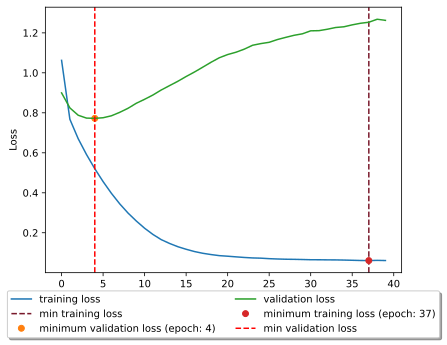

In [93]:
plot_training_validation_loss(training_losses, valid_losses)


#### Experiment using word masks to prevent overfitting


In [94]:
decoder2 = DecoderRNN(len(vocab)).to(device)
if not os.path.exists('export/decoder-2.pkl'):
    decoder2, training_losses2, valid_losses2 = train_decoder(
        decoder2, train_loader, val_loader, 'export/decoder-2.pkl', num_epochs=EPOCHS, masking=True)
else:
    decoder2.train(False)
    checkpoint = torch.load('export/decoder-2.pkl')
    decoder2.load_state_dict(checkpoint['model_state_dict'])
    training_losses2 = checkpoint['training_losses']
    valid_losses2 = checkpoint['valid_losses']

    # check if we need to continue training
    if checkpoint['epoch'] != EPOCHS:
        decoder2, training_losses2, valid_losses2 = train_decoder(
            decoder2, train_loader, val_loader, 'export/decoder-2.pkl', num_epochs=EPOCHS, masking=True)

del decoder2


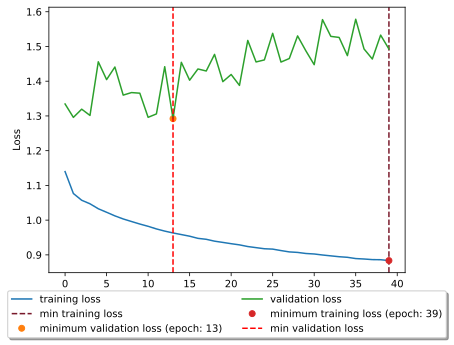

In [95]:
plot_training_validation_loss(training_losses2, valid_losses2)


## 4 Generate predictions on test data [8 marks]


In [96]:
def extract_n_most_likely_words(pred, n=1):
    pred_ids = np.argsort(pred, axis=1)[:, -n:]
    return pred_ids

def get_5_references(index):
    references = []
    image_id = test_captions.iloc[index]['image_id']
    for i, row in test_captions.iterrows():
        if row['image_id'] == image_id:
            references.append(row['cleaned_caption'])
            if len(references) == 5:
                break
    return references

def test_decoder(decoder, test_loader, num_samples=5, num_hypotheses=1):
    references = []
    hypotheses = []

    for i, (features, captions, caption_true_length) in enumerate(test_loader):
        if i == num_samples:
            break

        features = features.to(device)
        captions = captions.to(device)

        #---------------- Hypotheses ----------------#
        pred = decoder(features, captions,
                       caption_true_length).cpu().detach().numpy()

        # select the most likely word
        pred_ids = extract_n_most_likely_words(pred, n=1)

        pred_caption = []
        for word_ids in pred_ids.tolist():
            for word_id in word_ids:
                if word_id < 0:
                    continue

                word = vocab.idx2word[word_id]
                if word == '<end>':
                    break

                # strip pad token
                if word == '<pad>':
                    continue

                pred_caption.append(word)

        pred_caption = ' '.join(pred_caption)

        #---------------- References ----------------#
        captions = captions.cpu().detach().numpy()
        true_caption = []
        for word_id in captions[0]:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            true_caption.append(word)

        true_caption = ' '.join(true_caption)

        references.append([true_caption])
        hypotheses.append(pred_caption)

    return references, hypotheses


In [97]:
test_dataset = COCO_Subset(
    test_captions, features, vocab)


initializing dataset...
dataset size: 5034
vocabulary size: 6375
image features size: torch.Size([8000, 2048]), dtype: torch.float32, 8000


In [98]:
test_loader = DataLoader(test_dataset, batch_size=1,
                         shuffle=False, num_workers=0)


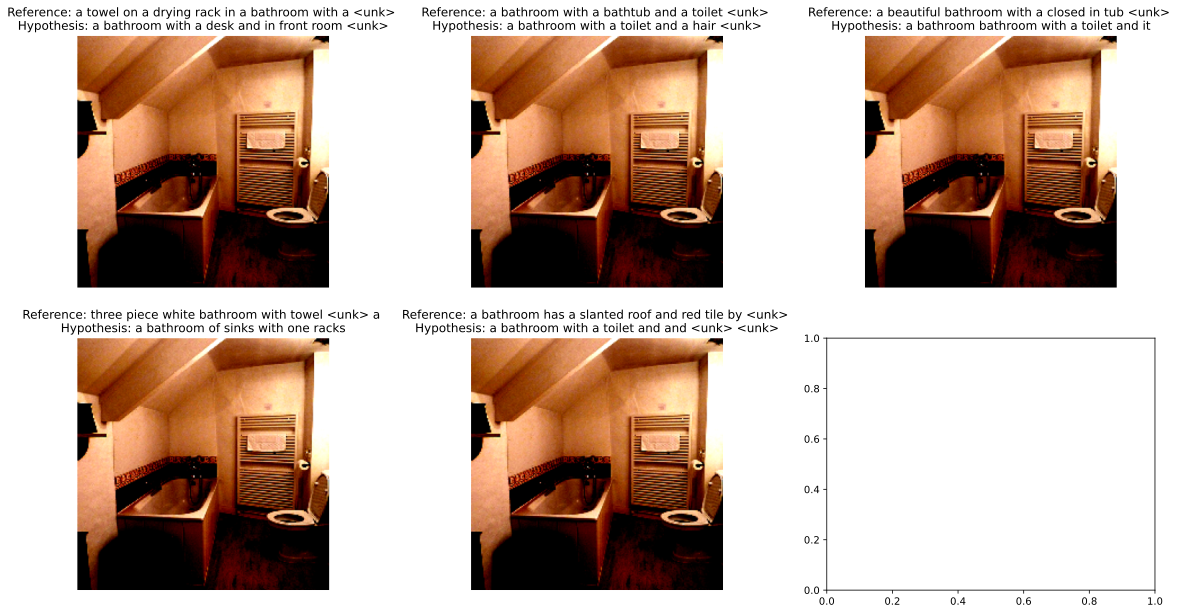

In [99]:
references, hypotheses = test_decoder(decoder, test_loader, 5)

# plot reference and hypothesis with the image
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):  # type: ignore
    if i >= len(references):
        break

    image_id = test_captions.iloc[i]['image_id']
    image_path = dataset.coco_frame[dataset.coco_frame['id']
                                    == image_id]['file_name'].values[0]
    image_path = os.path.join(dataset.root_dir, image_path)
    img = plt.imread(image_path)
    # convert single channel images to 3 channels
    if len(img.shape) == 2:
        image = np.stack((img,)*3, axis=-1)
    image = data_transform(img).numpy()
    # convert from CxHxW to HxWxC
    img = image.transpose(1, 2, 0)
    img = np.clip(img, 0, 1)  # clip values to [0, 1]
    ax.imshow(img)
    ax.set_title(
        f"Reference: {references[i][0]} \nHypothesis: {hypotheses[i]}")
    ax.axis('off')


## 5 Caption evaluation using BLEU score [10 marks]

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


In [100]:
# evaluate whole test dataset
references, hypotheses = test_decoder(
    decoder, test_loader, num_samples=np.iinfo(np.int32).max, num_hypotheses=5)

In [101]:
# calculate BLEU-4 scores
from nltk.translate.bleu_score import corpus_bleu
bleu4 = corpus_bleu(references, hypotheses)
print(f'BLEU-4 score = {bleu4*100:.2f}')

BLEU-4 score = 41.59


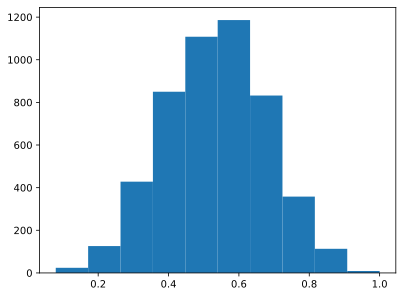

In [102]:
# display histogram of bleu scores over the test set
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
bleu_scores = []
for i in range(len(references)):
    # a smoothing function was chosen to avoid n-gram overlaps that result in a score of 0
    # a unfirom weight was chosen for each n-gram, considering the captions are fairly long
    bleu_scores.append(sentence_bleu(get_5_references(
        i), hypotheses[i], smoothing_function=SmoothingFunction().method1, weights=(0.25, 0.25, 0.25, 0.25)))
plt.hist(bleu_scores)
plt.show()


### 5.2 BLEU score examples


In [103]:
# find sample with high bleu score
max_bleu = max(bleu_scores)
max_bleu_index = bleu_scores.index(max_bleu)

# find sample with low bleu score
min_bleu = min(bleu_scores)
min_bleu_index = bleu_scores.index(min_bleu)

# display the model's predicted sentences, the BLEU scores, and the 5 reference captions.
print(f"Sample with high BLEU score ({max_bleu*100:.2f}):")
print(f"Predicted: {' '.join(hypotheses[max_bleu_index])}")
print(f"True: {get_5_references(max_bleu_index)}")
print()

print(f"Sample with low BLEU score ({min_bleu*100:.2f}):")
print(f"Predicted: {' '.join(hypotheses[min_bleu_index])}")
print(f"True: {get_5_references(min_bleu_index)}")
print()


Sample with high BLEU score (100.00):
Predicted: a   l i t t l e   g i r l s   a r e   p l a y i n g   w i t h   a   h a i r   d r y e r
True: ['two toddlers are playing with a hair driver ', 'a couple of little girls standing next to each other ', 'two little girls who have a hair dryer ', 'two young children standing in a room while one plays with a hair dryer ', 'two little girls are playing with a hair dryer in a library room ']

Sample with low BLEU score (7.94):
Predicted: a   k i t e s   a n d   o n   o n   a   < u n k >   o f
True: ['colorful opened umbrellas are arranged outside of the store windows ', 'a bunch of umbrellas are in front of a house', 'a bunch of umbrellas are opened next to each other ', 'many umbrellas sitting open against the side of a building ', 'large group of colorful umbrellas sitting next to each other ']



## 6 Caption evaluation using cosine similarity [12 marks]

###  6.1 Cosine similarity

In [104]:
# Find the embedding vector of each word in the caption
# and average them to get the embedding vector of the caption.
def get_caption_embedding(caption):
    caption_embedding = torch.zeros(1, 1, 300)
    embedding = nn.Embedding(len(vocab), 300)
    for word in caption:
        word_embedding = embedding(torch.tensor([vocab.word2idx[word]]))
        caption_embedding += word_embedding
    return caption_embedding / len(caption)


In [105]:
# compute the average vector for each caption
caption_embeddings = []
for i in range(len(references)):
    caption_embeddings.append(get_caption_embedding(references[i][0].split()))


In [106]:
# Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = []
for i in range(len(references)):
    cosine_similarities.append(cosine_similarity(caption_embeddings[i].detach().numpy().reshape(
        1, -1), get_caption_embedding(hypotheses[i].split()).detach().numpy().reshape(1, -1))[0][0])


In [107]:
# Compute the average of these scores
avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f"Average cosine similarity: {avg_cosine_similarity}")


Average cosine similarity: -0.0003577596300836056


#### 6.2 Cosine similarity examples 

Sample with high cosine similarity score (20.00):
Predicted: a   m a n   s i t t i n g   a   t a b l e   a n d   a   w o m a n   s i t t i n g   a   < u n k >   < u n k >
True: ['a young man sitting with a laptop computer on his lap ', 'a man playing a video game as his friend looks at a laptop screen', 'a guy on a laptop and a guy holding a wii remote ', 'a guy is playing wii with his friend ', 'a man is playing a video game while his friend is on his laptop ']

Sample with low cosine similarity score (-22.39):
Predicted: a   w h i t e   c a k e   a n d   a   c u p   o n   t o   b e
True: ['a white plate with a brownie and white frosting ', 'a piece of chocolate cake on top of a white plate ', 'a chocolate cake and a fork ready to be eat', 'a chocolate desert on a plate with a fork ', 'a piece of chocolate dessert on a plate with a napkin and a fork ']



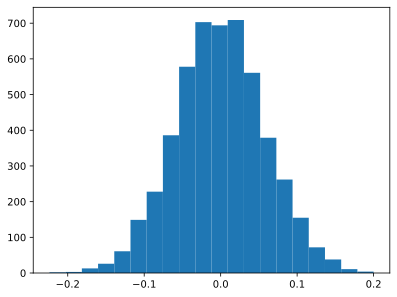

In [108]:
# Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.
max_cosine_similarity = max(cosine_similarities)
max_cosine_similarity_index = cosine_similarities.index(max_cosine_similarity)

min_cosine_similarity = min(cosine_similarities)
min_cosine_similarity_index = cosine_similarities.index(min_cosine_similarity)

print(
    f"Sample with high cosine similarity score ({max_cosine_similarity*100:.2f}):")
print(f"Predicted: {' '.join(hypotheses[max_cosine_similarity_index])}")
print(f"True: {get_5_references(max_cosine_similarity_index)}")
print()

print(
    f"Sample with low cosine similarity score ({min_cosine_similarity*100:.2f}):")
print(f"Predicted: {' '.join(hypotheses[min_cosine_similarity_index])}")
print(f"True: {get_5_references(min_cosine_similarity_index)}")
print()

# display histogram of cosine similarity scores over the test set
plt.hist(cosine_similarities, bins=20)
plt.show()


## 7 Comparing BLEU and Cosine similarity [16 marks]

### 7.1 Test set distribution of scores


In [109]:
# compare the BLEU-4 score and the average cosine similarity score
print(f"BLEU-4 score = {bleu4:.2f}")
# rescale cosine similarity score to be in the same range as the BLEU-4 score using minmax scaling
cosine_similarities = (cosine_similarities - min(cosine_similarities)) / \
    (max(cosine_similarities) - min(cosine_similarities))
avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f"Average cosine similarity (rescaled): {avg_cosine_similarity}")


BLEU-4 score = 0.42
Average cosine similarity (rescaled): 0.5273635153189512


 ### 7.2 Analysis of individual examples

In [110]:
# find one example that the BLEU score and the cosine similarity score is similar
score_distance = np.abs(bleu_scores - cosine_similarities)
# select the example with the smallest distance
min_distance_index = np.argmin(score_distance)

reference_captions = get_5_references(min_distance_index)

print(
    f"Sample with similar BLEU score: {bleu_scores[min_distance_index]*100:.2f} and cosine similarity score: {cosine_similarities[min_distance_index]*100:.2f}:")
print(f"Predicted: {' '.join(hypotheses[min_distance_index])}")
print(f"True: {[caption for caption in reference_captions]}")
print()

# find one example that the BLEU score and the cosine similarity score is different
# select the example with the largest distance
max_distance_index = np.argmax(score_distance)

reference_captions = get_5_references(max_distance_index)

print(
    f"Sample with different BLEU score: {bleu_scores[max_distance_index]*100:.2f} and cosine similarity score: {cosine_similarities[max_distance_index]*100:.2f}:")
print(f"Predicted: {' '.join(hypotheses[max_distance_index])}")
print(f"True: {[caption for caption in reference_captions]}")


Sample with similar BLEU score: 52.47 and cosine similarity score: 52.47:
Predicted: a   p e r s o n   h y d r a n t   i s   i s   b e e n   o n   a   s i d e   < u n k >
True: ['a fire hydrant is spilling water on the street', 'a fire hydrant spewing water on a snowy street', 'water flows out of fire hydrant into street ', 'an orange fire hydrant with water coming out of it on a cold day ', 'a fire hydrant that has burst and the water is now frozen ']

Sample with different BLEU score: 14.56 and cosine similarity score: 82.33:
Predicted: a   b a s e b a l l   u p   a   o n   o n   o n   < u n k >
True: ['an older model harley davidson motorcycle in a room ', 'the bike has red on it as well as the number ', 'an old red and white motorcycle parked on display in a building ', 'an old motorcycle is parked inside a building ', 'a motorbike and bicycle parked outside a building ']


### Overall quality [5 marks]


The overall performance of the model is not very good by normal standards. On the test set an average score of **0.41** was achieved using **BLEU** and **0.47** using Cosine similarity. In most cases the model is not able to generate a caption that is similar to the reference captions as show also by the histogram of the distribution of scores over the test set. Additionaly, we noticed overfitting in the training and validation loss curves due to the fact that the training loss is much lower than the validation loss. This is a sign that the model is not generalizing well. On the other hand, the model is sometimes able to generate a caption that is similar to the reference captions as shown by the examples above. It was definetely a challenge to train the model and to get it to work. Different approaches were tried in attempt to improve the model's accuracy, without any success.